# **Text2TextureGAN**

**Abstract**


---

In recent years, Generative Adversarial Networks (GANs) have undergone remarkable advancements. This research aims to leverages GAN techniques to innovate in the domain of texture synthesis. We present the Text2Texture GAN (T2TGAN), a novel approach in the domain of texture synthesis, tailored for generating textures directly from textual prompts. Envisioned as a valuable asset for artists, developers, professionals and laypersons within the 3D digital industry. T2TGAN is built upon the integration of state-of-the-art Natural Language Pro-cessing (NLP) techniques and GAN frameworks. T2TGAN aims to fulfill the gap present in texture synthesis by innovat-ing on traditional texture synthesis methods. While the sys-tem's potential is palpable, the study encountered specific chal-lenges, including overfitting, dataset limitations, and computa-tional restrictions affecting the model's intricate design. Through robust quantitative and qualitative evaluations, we gather comprehensive insights into the system's competencies and identify possibilities that warrant improvement. Despite the identified challenges, the T2TGAN exemplifies a crucial step in the exploration of automated texture generation from textual prompts, presenting a significant contribution to the field of texture synthesis.



---



In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 14.4 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.8 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow-gan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 6.0 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_gan as tfgan
from datasets import load_dataset
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab import drive
from PIL import JpegImagePlugin
from transformers import BertTokenizer, BertModel
from datasets import DatasetDict, Dataset
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import layers
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU, Concatenate
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Dense, Flatten, Concatenate, LayerNormalization, Reshape
from tensorflow.keras.models import Model
import pandas as pd
import os

drive.mount("/content/gdrive") #Mount drive for output samples

#Load the dataset
#LOAD TEXTURES 1K WITH NORMALS
dataset_color = load_dataset("dream-textures/textures-color-1k")
dataset_normal = load_dataset("dream-textures/textures-normal-1k")

output_folder = "Output/"
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

Mounted at /content/gdrive


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1426 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1447 [00:00<?, ? examples/s]

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.12.0


**Note: Make sure that TensorFlow version is 2.12.0**


---


**Google Drive is recommended but not required, it is only used for saving output of the GAN periodically during the training process. Simply comment out `drive.mount("/content/gdrive")` if not using Google Colab**.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def encode_prompts(prompt):

    encoded_prompt = tokenizer.encode_plus(prompt,
                                           add_special_tokens=True,
                                           max_length=18,
                                           padding='max_length',
                                           return_tensors='tf')

    embeddings = bert_model(encoded_prompt['input_ids'], attention_mask=encoded_prompt['attention_mask'])[0]

    #Average the embeddings across the sequence length dimension to get a single vector
    averaged_embeddings = tf.reduce_mean(embeddings, axis=1)

    return averaged_embeddings

color_mapping = {}
normal_mapping = {}

for i in range(len(dataset_color['train'])):
    try:
        entry = dataset_color['train'][i]
        image = entry['image'].convert("RGB").resize((64, 64))
        image = img_to_array(image) / 255.0  # Normalize the image
        color_mapping[entry['text']] = image
    except Exception as e:
        print(f"Skipping entry at index {i} in color dataset due to error: {e}")

for i in range(len(dataset_normal['train'])):
    try:
        entry = dataset_normal['train'][i]
        image = entry['image'].convert("RGB").resize((64, 64))
        image = img_to_array(image) / 255.0  # Normalize the image
        normal_mapping[entry['text']] = image
    except Exception as e:
        print(f"Skipping entry at index {i} in normal dataset due to error: {e}")

color_data = []
normal_data = []
prompt_data = []

for prompt, color_image in color_mapping.items():
    # Check if the prompt is also in the normal dataset
    if prompt in normal_mapping:
        # append the color image, normal image, and prompt to the respective lists
        color_data.append(np.array(color_image))
        normal_data.append(np.array(normal_mapping[prompt]))
        prompt_data.append(prompt)


# Convert the lists to Tensorflow datasets (for better workflow)
color_dataset = tf.data.Dataset.from_tensor_slices(color_data)
normal_dataset = tf.data.Dataset.from_tensor_slices(normal_data)
prompt_data = [encode_prompts(prompt) for prompt in prompt_data]
prompt_dataset = tf.data.Dataset.from_tensor_slices(prompt_data)
# Combine the datasets into a single dataset of tuples
combined_data = tf.data.Dataset.zip((color_dataset, normal_dataset, prompt_dataset))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Skipping entry at index 1024 in color dataset due to error: cannot identify image file <_io.BytesIO object at 0x7855c9b33ec0>


In [ ]:
class ResidualBlock(layers.Layer):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = layers.Conv2D(channels, 3, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv2D(channels, 3, padding='same')
        self.bn2 = layers.BatchNormalization()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return layers.add([inputs, x])

class SelfAttention(layers.Layer):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.query = layers.Dense(channels//8)
        self.key = layers.Dense(channels//8)
        self.value = layers.Dense(channels)

    def call(self, inputs):
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)
        attn = tf.nn.softmax(tf.matmul(q, k, transpose_b=True))
        out = tf.matmul(attn, v)
        return layers.add([inputs, out])

def build_generator(latent_dim, prompt_dim):
    # noise input
    noise = layers.Input(shape=(latent_dim,))
    x_noise = layers.Dense(128 * 16 * 16)(noise)
    x_noise = layers.BatchNormalization()(x_noise)
    x_noise = layers.LeakyReLU(alpha=0.2)(x_noise)
    x_noise = layers.Reshape((16, 16, 128))(x_noise)

    # prompt input
    prompt = layers.Input(shape=(prompt_dim,))
    x_prompt = layers.Dense(128 * 16 * 16)(prompt)
    x_prompt = layers.BatchNormalization()(x_prompt)
    x_prompt = layers.LeakyReLU(alpha=0.2)(x_prompt)
    x_prompt = layers.Reshape((16, 16, 128))(x_prompt)

    # concatenate the processed noise and prompt inputs
    x = layers.Concatenate()([x_noise, x_prompt])


    x = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = ResidualBlock(128)(x)

    x = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = ResidualBlock(128)(x)

    x = SelfAttention(128)(x)

    output_color = layers.Conv2DTranspose(3, (4,4), activation='sigmoid', padding='same')(x)
    output_normal = layers.Conv2DTranspose(3, (4,4), activation='sigmoid', padding='same')(x)

    model = tf.keras.Model([noise, prompt], [output_color, output_normal])

    return model

In [ ]:
class SelfAttention(layers.Layer):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.query = layers.Dense(channels//8)
        self.key = layers.Dense(channels//8)
        self.value = layers.Dense(channels)

    def call(self, inputs):
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)
        attn = tf.nn.softmax(tf.matmul(q, k, transpose_b=True))
        out = tf.matmul(attn, v)
        return layers.add([inputs, out])


def build_discriminator(image_shape, prompt_shape):
    input_color = Input(shape=image_shape)
    input_normal = Input(shape=image_shape)
    input_prompt = Input(shape=(prompt_shape,))

    prompt_processed = Dense(np.prod(image_shape))(input_prompt)
    prompt_processed = Reshape(image_shape)(prompt_processed)

    # concatenate along channel dimension
    merged = Concatenate(axis=-1)([input_color, input_normal, prompt_processed])

    # downsampling layers
    x = Conv2D(64, (3,3), strides=(2,2), padding='same')(merged)
    x = LeakyReLU(alpha=0.2)(x)
    x = LayerNormalization()(x)

    x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = LayerNormalization()(x)

    # Self-Attention
    x = SelfAttention(128)(x)


    # flattening and dense output
    x = Flatten()(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model([input_color, input_normal, input_prompt], output)

    return model


In [ ]:
latent_dim = 100
image_shape = (64, 64, 3)
prompt_shape = 768
generator = build_generator(latent_dim, prompt_shape)
discriminator = build_discriminator(image_shape, prompt_shape)
#tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=True) #use to plot model


In [ ]:
def save_images(predictions, epoch):
    output_dir = 'gdrive/MyDrive/Output'
    os.makedirs(output_dir, exist_ok=True)
    for i, prediction in enumerate(predictions):
        img_array_np = prediction.numpy()
        #img_array = tf.img_from_array(img_array_np)
        img = Image.fromarray(img_array)
        img.save(f'{output_dir}/img_epoch_{epoch:04d}_{i:04d}.png')

In [ ]:
def calculate_fid(real_images, generated_images):
    # Size will be 299x299
    size = tfgan.eval.INCEPTION_DEFAULT_IMAGE_SIZE
    real_images = tf.image.resize(real_images, [size, size], method=tf.image.ResizeMethod.BILINEAR)
    generated_images = tf.image.resize(generated_images, [size, size], method=tf.image.ResizeMethod.BILINEAR)
    #real_activations = calculate_activations(real_images)
    #generated_activations = calculate_activations(generated_images)
    num_inception_images = 1
    num_batches = 71 // num_inception_images
    fid = tfgan.eval.frechet_inception_distance(real_images, generated_images, num_batches=num_batches)
    return fid.numpy()

In [ ]:
generator_loss_dict = {}
discriminator_loss_dict = {}
evaluation_dict = {}
def train_gan(generator, discriminator, dataset, epochs, batch_size):

    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    gen_optimizer = tf.keras.optimizers.Adam(1e-4)
    disc_optimizer = tf.keras.optimizers.Adam(1e-4)

    for epoch in range(epochs):
        # Batch size 71 (factor of dataset size)
        for batch in dataset.batch(batch_size):
            color, normal, prompt = batch
            prompt = tf.squeeze(prompt, axis=1)
            # Random noise vec
            noise = tf.random.normal((batch_size, 100))
            # Train discriminator
            with tf.GradientTape() as disc_tape:
                # Generate fake images
                generated_images = generator([noise, prompt], training=True)

                # Compute discriminator loss on real images
                real_output = discriminator([color, normal, prompt], training=True)
                real_loss = loss_fn(tf.ones_like(real_output), real_output)

                # Compute discriminator loss on gen images
                fake_output = discriminator([generated_images[0], generated_images[1], prompt], training=True)
                fake_loss = loss_fn(tf.zeros_like(fake_output), fake_output)

                # Total discriminator loss
                disc_loss = real_loss + fake_loss

            # Compute discriminator gradients and apply them
            disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

            # Train generator
            with tf.GradientTape() as gen_tape:
                # Generate fake images from noise and prompt
                generated_images = generator([noise, prompt], training=True)

                # Compute generator loss
                fake_output = discriminator([generated_images[0], generated_images[1], prompt], training=True)
                gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)

                # Compute generator gradients and apply them
                gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
                gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))

        print(f"Epoch: {epoch}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}")
        # Save losses to visualise later (not training here)
        generator_loss_dict[epoch] = gen_loss
        discriminator_loss_dict[epoch] = disc_loss
        # Model checkpoints every 250 epoch (not training for fid preds)
        if epoch % 250 == 0:
          predictions = generator([noise, prompt], training=False)
          save_images(predictions[0][0], epoch + 1)
        if epoch % 250 == 0:
            generator.save("generator", save_format='tf')
            discriminator.save("discriminator", save_format='tf')
            predictions = generator([noise, prompt], training=False)
            # FID Evaluation + save it to dictionary
            fid = calculate_fid(color.numpy(), predictions[0].numpy())
            evaluation_dict[epoch] = fid
            print(f"FID Score: {fid}")


train_gan(generator, discriminator, combined_data, 1000, 71)

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch: 0, Generator Loss: 3.423069715499878, Discriminator Loss: 0.27281156182289124


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/nest.py:917: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  structure[0], [func(*x) for x in entries],


FID Score: 419.2862243652344


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch: 1, Generator Loss: 3.7411954402923584, Discriminator Loss: 0.416233092546463
Epoch: 2, Generator Loss: 4.511541843414307, Discriminator Loss: 0.1860412210226059
Epoch: 3, Generator Loss: 7.49127197265625, Discriminator Loss: 0.6713445782661438
Epoch: 4, Generator Loss: 2.998845100402832, Discriminator Loss: 0.0726788341999054
Epoch: 5, Generator Loss: 5.2524189949035645, Discriminator Loss: 0.10830120742321014
Epoch: 6, Generator Loss: 6.916450500488281, Discriminator Loss: 0.43211424350738525
Epoch: 7, Generator Loss: 9.20042896270752, Discriminator Loss: 0.010031688958406448
Epoch: 8, Generator Loss: 6.645200252532959, Discriminator Loss: 0.1883300393819809
Epoch: 9, Generator Loss: 4.909965515136719, Discriminator Loss: 0.11770328879356384
Epoch: 10, Generator Loss: 11.231090545654297, Discriminator Loss: 0.0005044487188570201
Epoch: 11, Generator Loss: 4.088656425476074, Discriminator Loss: 0.13510505855083466
Epoch: 12, Generator Loss: 6.508144855499268, Discriminator Loss:

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/nest.py:917: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  structure[0], [func(*x) for x in entries],


FID Score: 371.53692626953125


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch: 251, Generator Loss: 0.6342260241508484, Discriminator Loss: 1.645615577697754
Epoch: 252, Generator Loss: 0.758347749710083, Discriminator Loss: 1.2656910419464111
Epoch: 253, Generator Loss: 0.6053431630134583, Discriminator Loss: 1.503817081451416
Epoch: 254, Generator Loss: 0.4694100618362427, Discriminator Loss: 1.7883009910583496
Epoch: 255, Generator Loss: 0.6273348927497864, Discriminator Loss: 1.248431921005249
Epoch: 256, Generator Loss: 0.5488095283508301, Discriminator Loss: 1.3588484525680542
Epoch: 257, Generator Loss: 0.37387752532958984, Discriminator Loss: 1.780780553817749
Epoch: 258, Generator Loss: 0.47282087802886963, Discriminator Loss: 1.5424518585205078
Epoch: 259, Generator Loss: 0.5783888101577759, Discriminator Loss: 1.2145013809204102
Epoch: 260, Generator Loss: 0.5367103815078735, Discriminator Loss: 1.2935090065002441
Epoch: 261, Generator Loss: 0.5719394683837891, Discriminator Loss: 1.475674033164978
Epoch: 262, Generator Loss: 0.857665479183197, 

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/nest.py:917: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  structure[0], [func(*x) for x in entries],


FID Score: 360.7720642089844


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch: 501, Generator Loss: 0.7001923322677612, Discriminator Loss: 1.5192551612854004
Epoch: 502, Generator Loss: 0.7107836008071899, Discriminator Loss: 1.5646586418151855
Epoch: 503, Generator Loss: 0.7480810880661011, Discriminator Loss: 1.526760220527649
Epoch: 504, Generator Loss: 0.8292467594146729, Discriminator Loss: 1.4366991519927979
Epoch: 505, Generator Loss: 0.8683090209960938, Discriminator Loss: 1.3979942798614502
Epoch: 506, Generator Loss: 0.9101272225379944, Discriminator Loss: 1.314049243927002
Epoch: 507, Generator Loss: 0.864385187625885, Discriminator Loss: 1.3294258117675781
Epoch: 508, Generator Loss: 0.7842822074890137, Discriminator Loss: 1.4284119606018066
Epoch: 509, Generator Loss: 0.7334832549095154, Discriminator Loss: 1.476024866104126
Epoch: 510, Generator Loss: 0.6635889410972595, Discriminator Loss: 1.4988951683044434
Epoch: 511, Generator Loss: 0.6129679083824158, Discriminator Loss: 1.4855120182037354
Epoch: 512, Generator Loss: 0.5557122826576233,

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/nest.py:917: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  structure[0], [func(*x) for x in entries],


FID Score: 387.492431640625


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch: 751, Generator Loss: 0.6768102645874023, Discriminator Loss: 1.4080429077148438
Epoch: 752, Generator Loss: 0.6615238785743713, Discriminator Loss: 1.4203426837921143
Epoch: 753, Generator Loss: 0.6694130301475525, Discriminator Loss: 1.3816485404968262
Epoch: 754, Generator Loss: 0.6645920872688293, Discriminator Loss: 1.3692495822906494
Epoch: 755, Generator Loss: 0.6505540013313293, Discriminator Loss: 1.3875690698623657
Epoch: 756, Generator Loss: 0.6493784785270691, Discriminator Loss: 1.3912811279296875
Epoch: 757, Generator Loss: 0.6594398021697998, Discriminator Loss: 1.3918049335479736
Epoch: 758, Generator Loss: 0.6572542786598206, Discriminator Loss: 1.4116795063018799
Epoch: 759, Generator Loss: 0.6556271314620972, Discriminator Loss: 1.4369637966156006
Epoch: 760, Generator Loss: 0.6567233204841614, Discriminator Loss: 1.4539374113082886
Epoch: 761, Generator Loss: 0.6565296649932861, Discriminator Loss: 1.4504467248916626
Epoch: 762, Generator Loss: 0.6548208594322

In [ ]:
import shutil
from google.colab import files
#Downloading saved models

shutil.make_archive('generator', 'zip', 'generator')
shutil.make_archive('discriminator', 'zip', 'discriminator')
files.download('generator.zip')
files.download('discriminator.zip')

In [ ]:
#Utility functions to save loss dictionaries
import json
import numpy as np
from google.colab import files

def save_dicts_to_files(generator_loss_dict, discriminator_loss_dict, evaluation_dict):
    generator_loss_dict = {k: float(v) for k, v in generator_loss_dict.items()}
    discriminator_loss_dict = {k: float(v) for k, v in discriminator_loss_dict.items()}

    with open('generator_loss_dict.json', 'w') as f:
        json.dump(generator_loss_dict, f)
    with open('discriminator_loss_dict.json', 'w') as f:
        json.dump(discriminator_loss_dict, f)

    evaluation_dict_str_keys = {str(k): float(v) for k, v in evaluation_dict.items()}

    with open('evaluation_dict.json', 'w') as f:
        json.dump(evaluation_dict_str_keys, f)


def download_dicts():
    files.download('generator_loss_dict.json')
    files.download('discriminator_loss_dict.json')
    files.download('evaluation_dict.json')

save_dicts_to_files(generator_loss_dict, discriminator_loss_dict, evaluation_dict)
download_dicts()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#To unzip the model
!unzip generator.zip

Archive:  generator.zip
   creating: generator/assets/
 extracting: generator/fingerprint.pb  
  inflating: generator/keras_metadata.pb  
  inflating: generator/saved_model.pb  
   creating: generator/variables/
  inflating: generator/variables/variables.data-00000-of-00001  
  inflating: generator/variables/variables.index  


In [ ]:
#Uncomment this to utilize encode_prompts function without pre-processing stage
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# def encode_prompts(prompt):

#     encoded_prompt = tokenizer.encode_plus(prompt,
#                                            add_special_tokens=True,
#                                            max_length=18,
#                                            padding='max_length',
#                                            return_tensors='tf')

#     embeddings = bert_model(encoded_prompt['input_ids'], attention_mask=encoded_prompt['attention_mask'])[0]

#     #Average the embeddings across the sequence length dimension to get a single vector
#     averaged_embeddings = tf.reduce_mean(embeddings, axis=1)

#     return averaged_embeddings

In [ ]:
#Loading model. Make sure generator folder is in hierarchy. If nested, provide full directory path.
generator = tf.keras.models.load_model('generator')

In [ ]:
#"asphalt clean concrete grey light"
#"brick bricks modern stone wall"


#Input prompt here
input_prompt = "brick bricks modern stone wall"
input_prompt = encode_prompts(input_prompt)
noise = tf.random.normal([1, 100])

generated_imgs = generator.predict([noise, input_prompt])

1/1 [==============================] - 0s 24ms/step


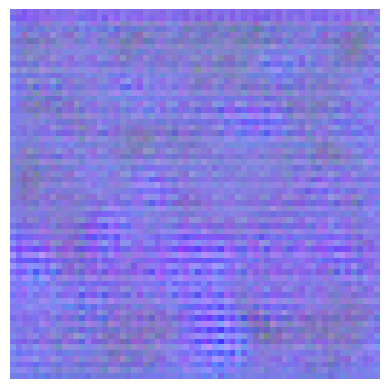

In [ ]:
def display_images(image):
    plt.imshow(image)
    plt.axis('off')  # Turn off the axis numbers
    plt.show()

color = 0
normal = 1

#Two images generated, replace first index with desired image ("color", "normal")
display_images(generated_imgs[normal][0])
#normal output of texture [color][0] displayed